In [1]:
import keras
import csv
import os
import itertools
import numpy as np
from keras.layers import Dropout, Flatten, Dense, Input, MaxPooling2D
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg19 import VGG19
from keras import backend as k
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
ROOT_DIR = os.path.normpath(os.path.join(os.path.dirname(os.path.realpath('__file__'))))
TRAIN_DIR = os.path.join(ROOT_DIR, 'data', 'train')
TEST_DIR =  os.path.join(ROOT_DIR, 'data', 'validation')

In [4]:
img_width, img_height = 300, 300

In [5]:
batch_size = 32
epoch = 10
drop_prob = 0.5
out_class = 13

In [6]:
train_gen = ImageDataGenerator(rescale=1. / 255, zoom_range=0.2, horizontal_flip = True, vertical_flip = True)

In [7]:
test_gen = ImageDataGenerator(rescale=1. / 255)

In [8]:
train_generator = train_gen.flow_from_directory(TRAIN_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 152397 images belonging to 13 classes.


In [9]:
'''val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')'''

"val_generator = test_gen.flow_from_directory(VAL_DIR, target_size=(img_width, img_height), \n                                                batch_size=batch_size, class_mode='categorical')"

In [10]:
test_generator = test_gen.flow_from_directory(TEST_DIR, target_size=(img_width, img_height), 
                                                batch_size=batch_size, class_mode='categorical')

Found 55388 images belonging to 13 classes.


In [11]:
input_ = Input(shape=(img_width, img_height, 3))
transfer_model = VGG19(input_tensor = input_, weights = 'imagenet', include_top = False)

In [12]:
x = transfer_model.output

x = MaxPooling2D(pool_size = 2, strides = 2)(x)

x = Flatten()(x)

x = Dropout(drop_prob)(x)

out = Dense(out_class, activation = 'softmax')(x)

In [13]:
model = Model(inputs = transfer_model.input, outputs = out)

In [14]:
adam_ = optimizers.Adam(lr = 1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [15]:
for layer in transfer_model.layers:
    layer.trainable = False

In [16]:
model.compile(loss = 'categorical_crossentropy', optimizer = adam_, metrics = ['accuracy'])

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

In [ ]:
#tensorboard = TensorBoardColabCallback(TensorBoardColab()) #Using Tensorboard on google colab

In [ ]:
checkpointer = ModelCheckpoint(filepath='checkpoint_vgg19.h5', save_best_only=True)

In [ ]:
callback_list = [checkpointer]

In [18]:
history = model.fit_generator(train_generator, steps_per_epoch = int(152397/batch_size), epochs = epoch, shuffle = True)

Epoch 1/10
4762/4762 [==============================] - 2021s 424ms/step - loss: 0.6268 - acc: 0.7933
Epoch 2/10
4762/4762 [==============================] - 1990s 418ms/step - loss: 0.3301 - acc: 0.8884
Epoch 3/10
4762/4762 [==============================] - 1991s 418ms/step - loss: 0.2838 - acc: 0.9017
Epoch 4/10
4762/4762 [==============================] - 1992s 418ms/step - loss: 0.2608 - acc: 0.9089
Epoch 5/10
4762/4762 [==============================] - 1992s 418ms/step - loss: 0.2451 - acc: 0.9137
Epoch 6/10
4762/4762 [==============================] - 1988s 417ms/step - loss: 0.2353 - acc: 0.9169
Epoch 7/10
4762/4762 [==============================] - 1994s 419ms/step - loss: 0.2288 - acc: 0.9186
Epoch 8/10
4762/4762 [==============================] - 1994s 419ms/step - loss: 0.2224 - acc: 0.9210
Epoch 9/10
4762/4762 [==============================] - 2000s 420ms/step - loss: 0.2174 - acc: 0.9221
Epoch 10/10
4762/4762 [==============================] - 1999s 420ms/step - loss: 

In [19]:
Y_pred = model.predict_generator(test_generator, int(55388/batch_size+1))
y_pred = np.argmax(Y_pred, axis=1)

In [24]:
test_loss, test_accuracy = model.evaluate_generator(test_generator, int(55388/batch_size+1))

In [25]:
test_loss

4.036480912406702

In [26]:
test_accuracy

0.3309922727009032

In [ ]:
model_check = load_model('checkpoint_vgg19.h5')

In [ ]:
test_check_loss, test_check_acc = model_check.evaluate_generator(test_generator, int(795/batch_size+1))

In [ ]:
test_check_loss

In [ ]:
test_check_acc

In [27]:
target_names = ['aeroplane', 'bicycle', 'bus', 'car', 'horse', 'knife', 'motorcycle', 'person', 'plant', 
                'skateboard', 'train', 'truck']

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    print(cm)
    
    plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.tight_layout()

In [29]:
cnf = confusion_matrix(test_generator.classes, y_pred)

Confusion matrix
[[ 287   53  101  856  137   65  674    4  210   95  953  211]
 [ 256   47   79  818  121   59  665    3  199   86  902  240]
 [ 351   67  117 1040  149   95  886    8  305  118 1241  313]
 [ 781  153  263 2431  349  189 1980   14  647  269 2692  633]
 [ 323   57  126 1095  163   87  885    6  274  137 1275  263]
 [ 138   26   51  499   58   21  401    1  140   47  570  123]
 [ 432   67  153 1396  203  102 1079    4  373  141 1489  357]
 [ 306   40   88  937  141   70  782    2  241  111 1061  221]
 [ 302   57  120 1088  151   78  925    4  265  113 1150  296]
 [ 157   24   65  503   73   43  452    1  150   60  616  137]
 [ 327   46  106  912  147   79  838    3  265  112 1147  254]
 [ 431   94  143 1251  181   98 1109    7  367  128 1396  343]]


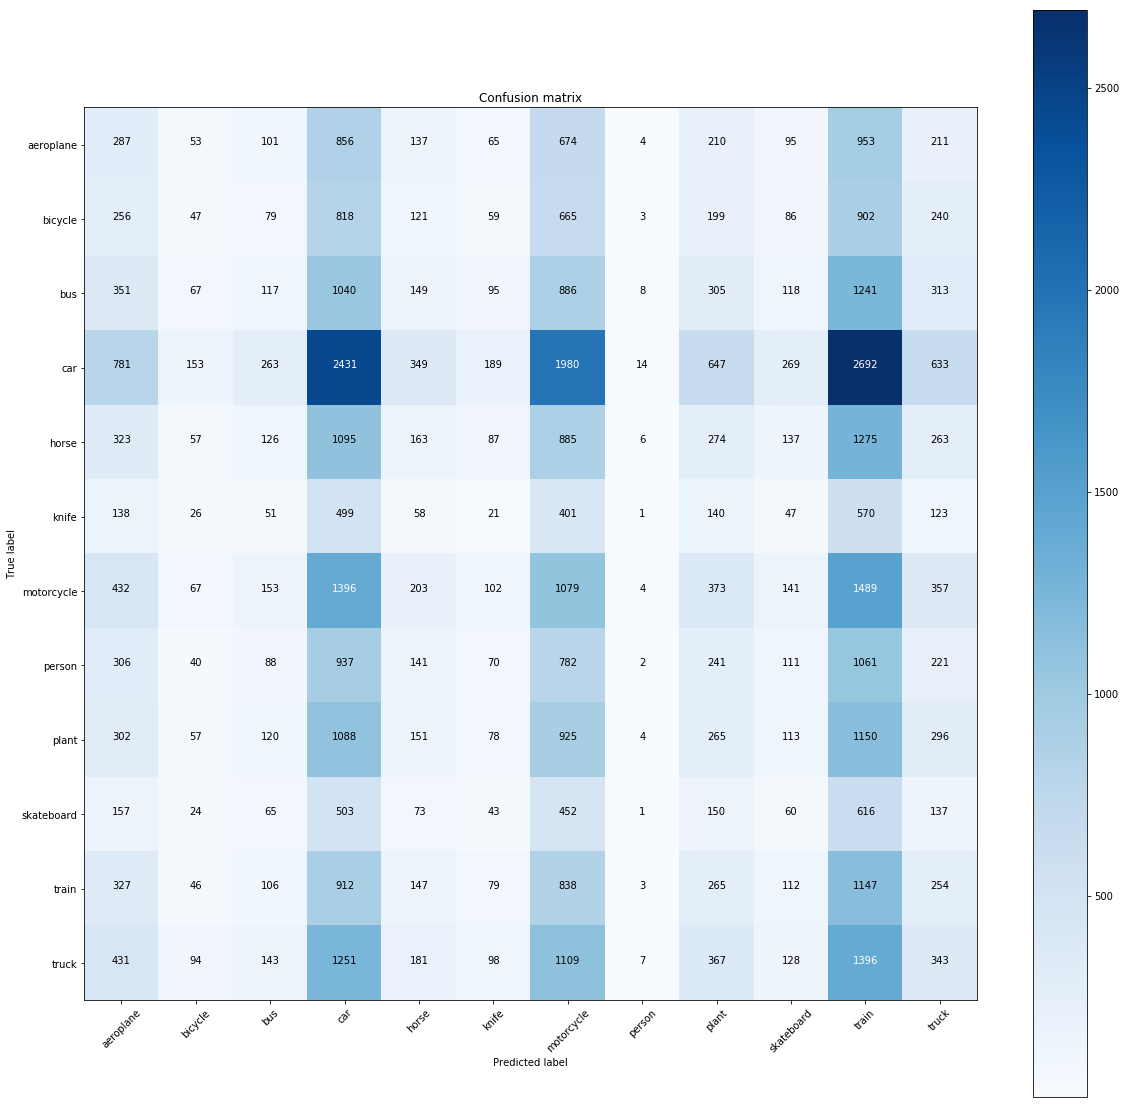

In [30]:
plot_confusion_matrix(cnf, classes=target_names, title='Confusion matrix')

In [31]:
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

   aeroplane       0.07      0.08      0.07      3646
     bicycle       0.06      0.01      0.02      3475
         bus       0.08      0.02      0.04      4690
         car       0.19      0.23      0.21     10401
       horse       0.09      0.03      0.05      4691
       knife       0.02      0.01      0.01      2075
  motorcycle       0.10      0.19      0.13      5796
      person       0.04      0.00      0.00      4000
       plant       0.08      0.06      0.07      4549
  skateboard       0.04      0.03      0.03      2281
       train       0.08      0.27      0.12      4236
       truck       0.10      0.06      0.08      5548

   micro avg       0.11      0.11      0.11     55388
   macro avg       0.08      0.08      0.07     55388
weighted avg       0.10      0.11      0.09     55388



In [32]:
model.save('vgg19.h5')